# KEP Core Workflow Check

Quick sanity run for the new compatibility, optimisation, and core modules.

In [10]:
from pathlib import Path

import numpy as np
import pandas as pd

from instance_analysis import load_instance
from KEP_functions import (
    build_compat_graph,
    core_heuristic,
    core_verification,
    enumerate_cycles,
    make_partition,
    max_size_solution,
    visualize_compatibility_graph,
    lexicographic_core_search,
    build_graph_features,
)

## Graph Assembly

In [11]:
instance = load_instance(Path("instances_large/genxml-0.xml"))
rng_graph = np.random.default_rng()
vertices, adj_out, adj_in, altruist_edges = build_compat_graph(
    instance, num_patients=1000, rng=rng_graph
)
print(f"vertices: {len(vertices)} | sample: {vertices[:5]}")
print(f"edges: {sum(len(v) for v in adj_out.values())}")

vertices: 1000 | sample: [1, 4, 5, 6, 8]
edges: 107534


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Compatibility Graph by Player'}>)

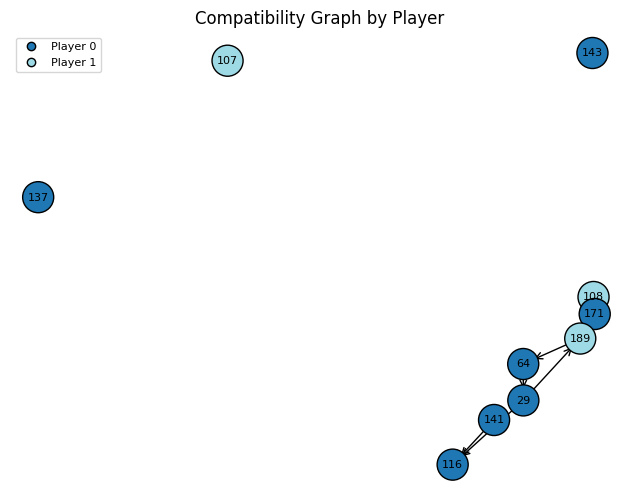

In [36]:
partition = make_partition(vertices, num_players=2, var_size=1, rng=rng_graph)
visualize_compatibility_graph(vertices, adj_out, partition)

## Cycle Database

In [12]:
rng_partition = np.random.default_rng(17)
partition = make_partition(vertices, num_players=15, var_size=1, rng=rng_partition)
cycle_db = enumerate_cycles(vertices, adj_out, partition, Delta=3)
print(f"cycles enumerated: {len(cycle_db.cycles)}")
for cycle in cycle_db.cycles[:5]:
    print(
        f"cycle {cycle.id}: {cycle.vertices} | players {sorted(cycle.players_in_cycle)}"
    )

cycles enumerated: 155039
cycle 0: (1, 169) | players [9, 13]
cycle 1: (1, 197) | players [6, 13]
cycle 2: (4, 41) | players [10, 14]
cycle 3: (4, 44) | players [1, 14]
cycle 4: (4, 64) | players [9, 14]


In [13]:
player_sizes = {player: len(vertices) for player, vertices in partition.vertices_of_player.items()}
player_sizes


{0: 63,
 1: 65,
 2: 160,
 3: 84,
 4: 29,
 5: 40,
 6: 83,
 7: 20,
 8: 100,
 9: 112,
 10: 72,
 11: 35,
 12: 23,
 13: 65,
 14: 49}

## Compatibility Graph Visual

Colour-coded by player ownership.

## Core Check Without Altruists

In [ ]:
solution = max_size_solution(cycle_db, Delta=3, partition=partition, solver="GUROBI")
in_core, blocking, baseline = core_verification(
    solution, cycle_db, partition, max_coal_size=2, Delta=3, solver="GUROBI"
)
print(f"solution cycles: {sorted(solution)}")
print(f"in core: {in_core}")
if not in_core:
    print(f"blocking coalition: {sorted(blocking)} | baseline: {baseline}")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2644044
Academic license 2644044 - for non-commercial use only - registered to cs___@student.elte.hu
solution cycles: [20, 28, 40, 42, 43, 52, 54, 55, 56, 65, 89, 90, 92, 106, 135, 137, 141, 156, 172, 181, 182, 207, 210, 211, 252, 256, 258, 260, 273, 278, 281, 289, 296, 298, 301, 302, 317, 329]
in core: True


## Heuristic With Altruist Augmentation

In [9]:
rng_heuristic = np.random.default_rng(314)
report = core_heuristic(
    vertices,
    adj_out,
    partition,
    Delta=3,
    solver="GUROBI",
    max_coal_size=5,
    max_altruists=7,
    rng=rng_heuristic,
    altruist_edges=altruist_edges
)
print(f"final in core: {report['final_in_core']}")
print(f"altruists added: {report['altruists_added']}")
print(f"objective value: {report['objective_value']}")
print(f"selected cycles: {sorted(report['solution'])}")
print(f"player utilities: {report['player_utilities']}")

final in core: True
altruists added: 0
objective value: 931
selected cycles: [38, 156, 208, 412, 432, 496, 518, 583, 818, 884, 1113, 1191, 1225, 1347, 1420, 1628, 1670, 1679, 1780, 1915, 1946, 1981, 2004, 2028, 2060, 2165, 2393, 2428, 2533, 2577, 2599, 2627, 2637, 2650, 2739, 2744, 2781, 2922, 2942, 2975, 3011, 3052, 3060, 3070, 3157, 3219, 3620, 3741, 3835, 3855, 3861, 3912, 3959, 3966, 4023, 4069, 4089, 4136, 4228, 4363, 4368, 4380, 4518, 4527, 4577, 4619, 4621, 4659, 4750, 5229, 5852, 6226, 6427, 6817, 6956, 7287, 9109, 9870, 10163, 11179, 11511, 11851, 12035, 12436, 12511, 12637, 12853, 13320, 14171, 14890, 15066, 15529, 16603, 17391, 17473, 21340, 23274, 23397, 23840, 24506, 24564, 25927, 26245, 26557, 28758, 29061, 29103, 29276, 30367, 30638, 30962, 31128, 31266, 31615, 32005, 32235, 36063, 37799, 38249, 39483, 39583, 39650, 39733, 40096, 40386, 40582, 41049, 41527, 41634, 42567, 42747, 42767, 43502, 43694, 43962, 44098, 44154, 44438, 44543, 44787, 45182, 45262, 46363, 47957, 482

In [ ]:
rng_heuristic = np.random.default_rng(314)
report = core_heuristic(
    vertices,
    adj_out,
    partition,
    Delta=2,
    solver="GUROBI",
    max_coal_size=15,
    max_altruists=7,
    rng=rng_heuristic,
    altruist_edges=altruist_edges
)
print(f"final in core: {report['final_in_core']}")
print(f"altruists added: {report['altruists_added']}")
print(f"objective value: {report['objective_value']}")
print(f"selected cycles: {sorted(report['solution'])}")
print(f"player utilities: {report['player_utilities']}")

(3, 134, 157)

## Simulation: Altruists Needed

Sweep every instance and player-count combination to record how many altruist donors the heuristic requires to reach the core.

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

from instance_analysis import load_instance
from KEP_functions import (
    build_compat_graph,
    core_heuristic,
    core_verification,
    enumerate_cycles,
    make_partition,
    delete_cross_player_edges,
    max_size_solution,
    visualize_compatibility_graph,
)

player_grid = [50]
instance_paths = sorted(Path('instances_large').glob('genxml-*.xml'))[2:7]
simulation_records = []

def _stable_seed(label: str) -> int:
    return sum(ord(ch) for ch in label) % (2**32)

for path in instance_paths:
    instance = load_instance(path)
    vertices, adj_out, adj_in, altruist_edges = build_compat_graph(instance, num_patients = 400)
    seed_base = _stable_seed(path.name)
    for num_players in player_grid:
        partition_seed = (seed_base * 31 + num_players * 17) % (2**32)
        partition_rng = np.random.default_rng(partition_seed)
        heuristic_rng = np.random.default_rng((partition_seed + 1) % (2**32))
        partition = make_partition(
            vertices,
            num_players=num_players,
            var_size=1,
            rng=partition_rng,
        )
        adj_out = delete_cross_player_edges(adj_out, partition, p=0.0)
        report = core_heuristic(
            vertices,
            adj_out,
            partition,
            Delta=2,
            solver='GUROBI',
            max_coal_size=2,
            max_altruists=max(len(altruist_edges), 1),
            rng=heuristic_rng,
            altruist_edges=altruist_edges,
        )
        simulation_records.append(
            {
                'instance': path.name,
                'num_players': num_players,
                'altruists_needed': report['altruists_added'],
            }
        )

simulation_df = (
    pd.DataFrame(simulation_records)
    .set_index(['instance', 'num_players'])
    .sort_index()
)
simulation_df


,,altruists_needed
instance,num_players,
genxml-2.xml,50,0
genxml-3.xml,50,0
genxml-4.xml,50,0
genxml-5.xml,50,0
genxml-6.xml,50,0


In [ ]:
simulation_pivot = (
    simulation_df
    .reset_index()
    .pivot(index='instance', columns='num_players', values='altruists_needed')
)
simulation_pivot


num_players,5,6,8,12,15
instance,,,,,
genxml-0.xml,0,0,0,0,0
genxml-1.xml,0,0,0,0,0
genxml-2.xml,0,0,0,0,0
genxml-3.xml,0,0,0,0,0
genxml-4.xml,0,0,0,0,0


In [ ]:
# TU Core (Simple) with Altruists
from pathlib import Path

import numpy as np
import pandas as pd

from instance_analysis import load_instance
from KEP_functions import (
    build_compat_graph,
    core_heuristic,
    core_verification,
    enumerate_cycles,
    make_partition,
    delete_cross_player_edges,
    max_size_solution,
    visualize_compatibility_graph,
)
from KEP_functions import core_tu_simple

player_grid = [20]
 

instance_paths = sorted(Path('instances_large').glob('genxml-*.xml'))
#instance_paths = sorted(Path('instances_large').glob('genxml-*.xml'))
simulation_records = []

def _stable_seed(label: str) -> int:
    return sum(ord(ch) for ch in label) % (2**30)

for path in instance_paths:
    instance = load_instance(path)
    vertices, adj_out, adj_in, altruist_edges = build_compat_graph(instance, num_patients = 200)
    seed_base = _stable_seed(path.name)
    for num_players in player_grid:
        partition_seed = (seed_base * 31 + num_players * 17) % (2**32)
        partition_rng = np.random.default_rng(partition_seed)
        partition = make_partition(
            vertices,
            num_players=num_players,
            var_size=1,
            rng=partition_rng,
        )
        # Run for both Delta=3 and Delta=2 and record altruists_used
        for Delta in {2,3}:
            #print(Delta)
            report = core_tu_simple(
                vertices,
                adj_out,
                partition,
                Delta=Delta,
                solver='GUROBI',
                max_coal_size=min(3,num_players),
                altruist_edges=altruist_edges,
            )
            simulation_records.append(
                {
                    'instance': path.name,
                    'num_players': num_players,
                    'Delta': Delta,
                    'altruists_used': report['altruists_used'],
                }
            )

simulation_df_tu = (
    pd.DataFrame(simulation_records)
    .set_index(['instance', 'Delta', 'num_players'])
    .sort_index()
)
simulation_df_tu


2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


altruists_used
instance     Delta num_players                
genxml-0.xml 2     50                        2
             3     50                        0
genxml-1.xml 2     50                        1
             3     50                        0
genxml-2.xml 2     50                        2
             3     50                        1
genxml-3.xml 2     50                        3
             3     50                        0
genxml-4.xml 2     50                        0
             3     50                        0
genxml-5.xml 2     50                        5
             3     50                        1
genxml-6.xml 2     50                        0
             3     50                        0
genxml-7.xml 2     50                        1
             3     50                        0
genxml-8.xml 2     50                        3
             3     50                        0
genxml-9.xml 2     50                        1
             3     50                        0

In [14]:
# Strong Core Heuristic With Altruist Augmentation
from KEP_functions import strong_core_heuristic

player_grid = [50]
#instance_paths = sorted(Path('instances_large').glob('genxml-*.xml'))[:1]
instance_paths = sorted(Path('instances_large').glob('genxml-*.xml'))
simulation_records = []

def _stable_seed(label: str) -> int:
    return sum(ord(ch) for ch in label) % (2**32)

for path in instance_paths:
    instance = load_instance(path)
    vertices, adj_out, adj_in, altruist_edges = build_compat_graph(instance, num_patients=50)
    seed_base = _stable_seed(path.name)
    for num_players in player_grid:
        partition_seed = (seed_base * 31 + num_players * 17) % (2**32)
        partition_rng = np.random.default_rng(partition_seed)
        partition = make_partition(
            vertices,
            num_players=num_players,
            var_size=1,
            rng=partition_rng,
        )
        # Run for both Delta=3 and Delta=2 and record altruists_used
        for Delta in (3, 2):
            report = strong_core_heuristic(
                vertices,
                adj_out,
                partition,
                Delta=Delta,
                solver='GUROBI',
                max_coal_size=min(2,num_players),
                altruist_edges=altruist_edges,
            )
            simulation_records.append(
                {
                    'instance': path.name,
                    'num_players': num_players,
                    'Delta': Delta,
                    'altruists_used': report['altruists_added'],
                }
            )

simulation_df_strong = (
    pd.DataFrame(simulation_records)
    .set_index(['instance', 'Delta', 'num_players'])
    .sort_index()
)
simulation_df_strong


altruists_used
instance     Delta num_players                
genxml-0.xml 2     50                       10
             3     50                        7
genxml-1.xml 2     50                        0
             3     50                        0
genxml-2.xml 2     50                        7
             3     50                        5
genxml-3.xml 2     50                        1
             3     50                        1
genxml-4.xml 2     50                       10
             3     50                        3
genxml-5.xml 2     50                        7
             3     50                        7
genxml-6.xml 2     50                       10
             3     50                        0
genxml-7.xml 2     50                        9
             3     50                        5
genxml-8.xml 2     50                        3
             3     50                        0
genxml-9.xml 2     50                        6
             3     50                        3

In [3]:
simulation_records

[{'instance': 'genxml-0.xml',
  'num_players': 5,
  'Delta': 2,
  'altruists_used': 0},
 {'instance': 'genxml-0.xml',
  'num_players': 5,
  'Delta': 3,
  'altruists_used': 0},
 {'instance': 'genxml-0.xml',
  'num_players': 8,
  'Delta': 2,
  'altruists_used': 0},
 {'instance': 'genxml-0.xml',
  'num_players': 8,
  'Delta': 3,
  'altruists_used': 0},
 {'instance': 'genxml-0.xml',
  'num_players': 10,
  'Delta': 2,
  'altruists_used': 0}]

In [ ]:
## Test Instance: Empty Weak Core

# Create a specific test instance with:
# - 2 triangles (complete graphs on 3 vertices)
# - 3 complete graphs on 5 vertices (K5)
# - Every edge is bidirectional (2-cycle)
# - 3 players with specific partition

# Vertex numbering:
# Triangle 1: 0, 1, 2
# Triangle 2: 3, 4, 5
# K5_1: 6, 7, 8, 9, 10
# K5_2: 11, 12, 13, 14, 15
# K5_3: 16, 17, 18, 19, 20

vertices = list(range(21))
adj_out = {v: [] for v in vertices}

# Helper function to add bidirectional edge
def add_bidirectional_edge(u, v):
    if v not in adj_out[u]:
        adj_out[u].append(v)
    if u not in adj_out[v]:
        adj_out[v].append(u)

# Triangle 1 (0, 1, 2)
for i, u in enumerate([0, 1, 2]):
    for v in [0, 1, 2]:
        if u != v:
            add_bidirectional_edge(u, v)

# Triangle 2 (3, 4, 5)
for i, u in enumerate([3, 4, 5]):
    for v in [3, 4, 5]:
        if u != v:
            add_bidirectional_edge(u, v)

# K5_1 (6, 7, 8, 9, 10)
k5_1 = [6, 7, 8, 9, 10]
for u in k5_1:
    for v in k5_1:
        if u != v:
            add_bidirectional_edge(u, v)

# K5_2 (11, 12, 13, 14, 15)
k5_2 = [11, 12, 13, 14, 15]
for u in k5_2:
    for v in k5_2:
        if u != v:
            add_bidirectional_edge(u, v)

# K5_3 (16, 17, 18, 19, 20)
k5_3 = [16, 17, 18, 19, 20]
for u in k5_3:
    for v in k5_3:
        if u != v:
            add_bidirectional_edge(u, v)

# Add reserved altruist (ID 100) that is mutually compatible with vertex 0
# The altruist is reserved (not in initial graph) but will be added by heuristic if needed
altruist_id = 100

# When the altruist is added, it should have edge to vertex 0, and vertex 0 will get edge to altruist
# (the _add_altruist_vertex function adds edges from all base vertices to the altruist)
altruist_edges = {altruist_id: [0]}

# Create partition:
# Player 0: 1 from each triangle, 2 from K5_1, 2 from K5_2, 1 from K5_3
# Player 1: 1 from each triangle, 2 from K5_1, 1 from K5_2, 2 from K5_3
# Player 2: 1 from each triangle, 1 from K5_1, 2 from K5_2, 2 from K5_3

owner_of = {}
vertices_of_player = {0: [], 1: [], 2: []}

# Player 0: triangle1(0), triangle2(3), K5_1(6,7), K5_2(11,12), K5_3(16)
for v in [0, 3, 6, 7, 11, 12, 16]:
    owner_of[v] = 0
    vertices_of_player[0].append(v)

# Player 1: triangle1(1), triangle2(4), K5_1(8,9), K5_2(13), K5_3(17,18)
for v in [1, 4, 8, 9, 13, 17, 18]:
    owner_of[v] = 1
    vertices_of_player[1].append(v)

# Player 2: triangle1(2), triangle2(5), K5_1(10), K5_2(14,15), K5_3(19,20)
for v in [2, 5, 10, 14, 15, 19, 20]:
    owner_of[v] = 2
    vertices_of_player[2].append(v)

from KEP_functions import Partition

partition = Partition(
    owner_of=owner_of,
    vertices_of_player=vertices_of_player,
    players=[0, 1, 2]
)

# Optionally delete cross-player edges (default p=0 -> no deletion)
adj_out = delete_cross_player_edges(adj_out, partition, p=0.0)

print(f"Created test instance:")
print(f"  Vertices: {len(vertices)}")
print(f"  Total edges: {sum(len(neighbors) for neighbors in adj_out.values())}")
print(f"  Reserved altruist: {altruist_id} (mutually compatible with vertex 0)")
print(f"  Player 0 vertices: {sorted(vertices_of_player[0])}")
print(f"  Player 1 vertices: {sorted(vertices_of_player[1])}")
print(f"  Player 2 vertices: {sorted(vertices_of_player[2])}")

# Enumerate cycles
cycle_db = enumerate_cycles(vertices, adj_out, partition, Delta=2)
print(f"\nCycles enumerated: {len(cycle_db.cycles)}")
print(f"Sample cycles:")
for cycle in cycle_db.cycles[:10]:
    print(f"  Cycle {cycle.id}: vertices {cycle.vertices}, players {sorted(cycle.players_in_cycle)}")

# Test weak core heuristic
print("\n" + "="*60)
print("Testing weak core heuristic:")
print("="*60)

rng_test = np.random.default_rng(42)
report = core_heuristic(
    vertices,
    adj_out,
    partition,
    Delta=2,
    solver="GUROBI",
    max_coal_size=3,
    max_altruists=1,  # Allow 1 altruist
    rng=rng_test,
    altruist_edges=altruist_edges
)

print(f"\nResults:")
print(f"  Final in core: {report['final_in_core']}")
print(f"  Altruists added: {report['altruists_added']}")
print(f"  Objective value: {report['objective_value']}")
print(f"  Selected cycles: {sorted(report['solution'])}")
print(f"  Player utilities: {report['player_utilities']}")
print(f"  Cuts used: {len(report['cuts_used'])}")

if report['cuts_used']:
    print(f"\nBlocking coalitions found:")
    for i, cut in enumerate(report['cuts_used']):
        print(f"  Cut {i+1}: coalition {cut['coalition']}, RHS = {cut['rhs']}")



Created test instance:
  Vertices: 21
  Total edges: 72
  Reserved altruist: 100 (mutually compatible with vertex 0)
  Player 0 vertices: [0, 3, 6, 7, 11, 12, 16]
  Player 1 vertices: [1, 4, 8, 9, 13, 17, 18]
  Player 2 vertices: [2, 5, 10, 14, 15, 19, 20]

Cycles enumerated: 36
Sample cycles:
  Cycle 0: vertices (0, 1), players [0, 1]
  Cycle 1: vertices (0, 2), players [0, 2]
  Cycle 2: vertices (1, 2), players [1, 2]
  Cycle 3: vertices (3, 4), players [0, 1]
  Cycle 4: vertices (3, 5), players [0, 2]
  Cycle 5: vertices (4, 5), players [1, 2]
  Cycle 6: vertices (6, 7), players [0]
  Cycle 7: vertices (6, 8), players [0, 1]
  Cycle 8: vertices (6, 9), players [0, 1]
  Cycle 9: vertices (6, 10), players [0, 2]

Testing weak core heuristic:

Results:
  Final in core: True
  Altruists added: 1
  Objective value: 17
  Selected cycles: [2, 3, 5, 11, 16, 17, 24, 29, 33]
  Player utilities: {1: 5, 2: 6, 0: 6}
  Cuts used: 4

Blocking coalitions found:
  Cut 1: coalition [2], RHS = 4
  Cut

## Lexicographic Weak-Core Simulation

Explore the lexicographic objective with player grids [5, 10, 20] and track how many altruists are required to reach the core.

In [9]:
from pathlib import Path

import numpy as np
import pandas as pd

from instance_analysis import load_instance
from KEP_functions import (
    build_compat_graph,
    core_heuristic,
    core_verification,
    enumerate_cycles,
    make_partition,
    delete_cross_player_edges,
    max_size_solution,
    visualize_compatibility_graph,
    build_graph_features,
    lexicographic_core_search
)

lex_player_grid = [30]
lex_records = []
lex_instance_paths = sorted(Path('instances_large').glob('genxml-*.xml'))

for path in lex_instance_paths:
    instance = load_instance(path)
    vertices, adj_out, adj_in, altruist_edges = build_compat_graph(instance, num_patients=100)
    features = build_graph_features(instance)
    seed_base = sum(ord(ch) for ch in path.name) % (2**32)
    for num_players in lex_player_grid:
        partition_seed = (seed_base * 37 + num_players * 53) % (2**32)
        partition = make_partition(
            vertices,
            num_players=num_players,
            var_size=1,
            rng=np.random.default_rng(partition_seed),
        )
        result = lexicographic_core_search(
            vertices,
            adj_out,
            partition,
            Delta=2,
            graph_features=features,
            altruist_edges=altruist_edges,
            solver='GUROBI',
            max_coal_size=3,
            rng=np.random.default_rng((partition_seed + 1) % (2**32)),
        )
        lex_records.append(
            {
                'instance': path.name,
                'num_players': num_players,
                'altruists_needed': result['altruists_added'],
                'in_core': result['final_in_core'],
                'transplants': result['objective_tiers'].get('transplants', 0),
                'cycle_count': result['objective_tiers'].get('cycle_count', 0),
                'same_blood': result['objective_tiers'].get('same_blood', 0),
                'hard_match': result['objective_tiers'].get('hard_match', 0),
            }
        )

lexic_df = (
    pd.DataFrame(lex_records)
    .set_index(['instance', 'num_players'])
    .sort_index()
)
lexic_df


,,altruists_needed,in_core,transplants,cycle_count,same_blood,hard_match
instance,num_players,,,,,,
genxml-0.xml,30,2,True,53.0,37.0,38.0,2.425649
genxml-1.xml,30,0,True,34.0,17.0,28.0,1.410607
genxml-2.xml,30,0,True,56.0,28.0,44.0,2.104411
genxml-3.xml,30,0,True,34.0,17.0,29.0,1.528108
genxml-4.xml,30,0,True,44.0,22.0,33.0,1.733404
genxml-5.xml,30,0,True,36.0,18.0,32.0,1.285679
genxml-6.xml,30,0,True,36.0,18.0,27.0,1.839846
genxml-7.xml,30,0,True,34.0,17.0,27.0,1.499625
genxml-8.xml,30,1,True,47.0,26.0,38.0,1.753641
